## Applied - Question 9

The question involve Boston dataset - a data frame with 506 observations and 14 variables.
The data was originally published by Harrison, 
D. and Rubinfeld, D.L. `Hedonic prices and the demand for clean air', 
J. Environ. Economics & Management, vol.5, 81-102, 1978.

There are 14 attributes in each case of the dataset. They are:

  1. CRIM - per capita crime rate by town  
  2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
  3. INDUS - proportion of non-retail business acres per town.
  4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
  5. NOX - nitric oxides concentration (parts per 10 million)
  6. RM - average number of rooms per dwelling
  7. AGE - proportion of owner-occupied units built prior to 1940
  8. DIS - weighted distances to five Boston employment centres
  9. RAD - index of accessibility to radial highways
  10. TAX - full-value property-tax rate per $10,000
  11. PTRATIO - pupil-teacher ratio by town
  12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
  13. LSTAT - % lower status of the population
  14. MEDV - Median value of owner-occupied homes in $1000's

We will try to predict per capita crime rate using various methods.

#### Import block

In [23]:
from operator import itemgetter
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf
import statsmodels.api as sm

from forward_select import forward_select

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

Getting dataset

In [24]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}Boston.csv')

# Summary on crim rate
df.crim.describe()

# Get X and y
y = df.crim
X = df.drop('crim', axis=1)

# Set validation approach
kf = KFold(n_splits=10, shuffle=True, random_state=1)

Some notes before we started:
1. I will use RMSE to compare model
2. 10-fold will be the cross validation method
3. Forward select instead of best select. IMPORTANT: All select methods are BAD!
With all that out of the way, lets start with forward select

#### Forward Selection

The problem seems simple enough under validation set but not quite in k-fold (for me!)
The steps are as follow:
1. Split data into 10 fold
2. For each fold, run forward select to spit out 13 best model using 1 to 13 features.
3. For each model above, compute RMSE of each.
4. Each fold should have 13 model -> 13 RMSE
5. Record all 10 fold for 10x13 list. Calculate the mean of RMSE
6. Plot it out!

One important thing I learned which takes me HOURS in this small code: cross-validation
before feature selection or else you will introduce bias into the model.

Read [this](https://stats.stackexchange.com/questions/27750/feature-selection-and-cross-validation) 
here if you want to understand more!

Text(0.5, 1.0, 'mean_RMSE_CV vs features')

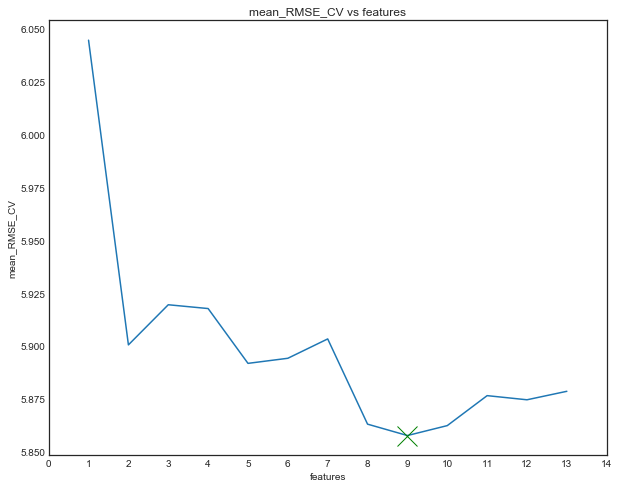

In [25]:
# Set a list to record all RMSE spit out by the loop
RMSE = []

# Loop over each fold in k fold
for train_index, test_index in kf.split(X):
    forward_df = forward_select(y[train_index], X.iloc[train_index], k=X.shape[1])
    RMSE_temp = []
    
    # Loop over each feature in the forward select 
    for feature in forward_df.features:
        # Run regression only on the selected features AND fold
        regr = skl_lm.LinearRegression().fit(X.iloc[train_index][feature], y[train_index])
        
        # Calculate RMSE and add to the list
        y_pred = regr.predict(X.iloc[test_index][feature])
        RMSE_temp.append(np.sqrt(mean_squared_error(y[test_index], y_pred)))
    
    # Add RMSE of each fold to the master list
    RMSE.append(RMSE_temp)

# Calculate mean RMSE of each num_features
rmse_cv = np.mean(RMSE, axis=0)

# Get min value
min_RMSE_index, min_RMSE = min(enumerate(rmse_cv), key=itemgetter(1))

# Plot it out
plt.figure(figsize=(10, 8))
plt.plot(range(1, 14), rmse_cv)
plt.plot(min_RMSE_index+1, min_RMSE, color='g', marker='x', markersize=20)
plt.xticks(np.arange(0,15,1))
plt.xlabel('features')
plt.ylabel('mean_RMSE_CV')
plt.title('mean_RMSE_CV vs features')

Cross-validation gives us the best model includes 9 features. We will use FULL dataset
to find which coefficients will be selected.

In [26]:
# Set up RMSE dictionary for comparison
RMSE_dict = {}

# Get the best features
forward_df = forward_select(y, X, k=X.shape[1])
features = forward_df.features[8]

# Run regression with the 9 features
regr = sm.OLS(y, sm.add_constant(X[features])).fit()
RMSE_dict['forward_select'] = np.sqrt(regr.mse_resid)
regr.summary().tables[1]

d:\pycharmprojects\islr\venv\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,coef,std err,t,P>|t|,[0.025,0.975]
const,19.1246,6.095,3.138,0.002,7.149,31.101
rad,0.5395,0.050,10.800,0.000,0.441,0.638
lstat,0.1178,0.069,1.698,0.090,-0.019,0.254
black,-0.0080,0.004,-2.215,0.027,-0.015,-0.001
medv,-0.1806,0.054,-3.335,0.001,-0.287,-0.074
zn,0.0428,0.018,2.381,0.018,0.007,0.078
dis,-1.0026,0.269,-3.725,0.000,-1.531,-0.474
nox,-10.4665,5.054,-2.071,0.039,-20.396,-0.537
ptratio,-0.2708,0.185,-1.463,0.144,-0.635,0.093
indus,-0.0994,0.074,-1.339,0.181,-0.245,0.046


#### Ridge Regression

Again I have some notes:
1. There is no training set and test set here. We use 10 folds.
2. I am quite confused by how does ridge cv vs CV on Ridge differ
3. No graphs are drawn below as no error is save if using kfold

I will try to approach this problem in 3 different ways (mainly because I am quite 
confused!). I want to use 10-fold validation techniques to find the best alphas and
the best model with that alpha. Thus 3 approaches are as followed:
1. Naive way: Run Ridge CV on the full dataset and plot out best alpha. Get model!
2. I will run Ridge CV for each split in K fold and find the RMSE, best alpha for each.
However, how to choose alpha? 
3. Using cross_val_score to run kfold on ridgecv with kfold - nested kfold to get 
the best RMSE. No idea how to get alpha!

#### Naive

With validation set, RidgeCV barely beat out the forward select here. The coefficients
are mostly the same here for both.

Validation set give RMSE of: 6.616890660504823
zn         0.044919
indus     -0.070331
chas      -0.764443
nox       -8.779610
rm         0.430875
age        0.000103
dis       -0.960708
rad        0.584057
tax       -0.003844
ptratio   -0.251098
black     -0.007505
lstat      0.126908
medv      -0.195425
dtype: float64
Intercept:  15.840455829313123


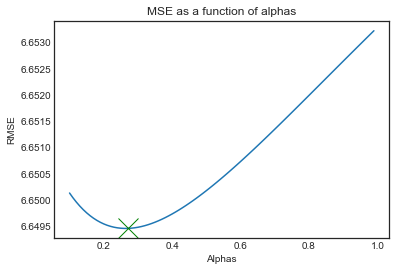

In [39]:
# Set alphas range
alphas = np.arange(0.1, 1, 0.01)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Running Ridge cv
ridge_cv = skl_lm.RidgeCV(alphas=alphas, fit_intercept=True,
                          scoring=None, cv=None, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Get RMSE
rmse_cv = np.sqrt(np.mean(ridge_cv.cv_values_, axis=0))

# Find the min MSE and alpha
min_RMSE_index, min_RMSE = min(enumerate(rmse_cv), key=itemgetter(1))

# Plot out the MSE for best alpha
plt.plot(ridge_cv.alphas, rmse_cv)
plt.plot(alphas[min_RMSE_index+1], min_RMSE, color='g', marker='x', markersize=20)
plt.xlabel('Alphas')
plt.ylabel('RMSE')
plt.title('MSE as a function of alphas')

# Plug the best alpha in Ridge Regression
ridge = skl_lm.Ridge(alpha=ridge_cv.alpha_, fit_intercept=True, random_state=1)
ridge.fit(X_train, y_train)
mse = mean_squared_error(y_test, ridge.predict(X_test))
print('Validation set give RMSE of:', np.sqrt(mse))

# Fit ridge with full dataset
ridge.fit(X, y)

# Return the model with coefficients
print(pd.Series(ridge.coef_, index=X.columns))
print('Intercept: ', ridge.intercept_)

#### 10 fold approach 

Here we get 10 different alphas with 10 different RMSE. The mean of our RMSE is 5.87
which is a bit lower than the approach given above.

MEAN of RMSE across 10 fold: 5.876812810655389


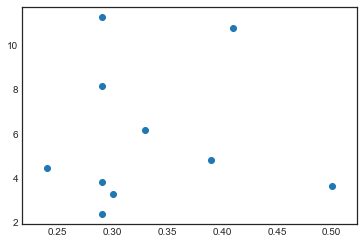

In [34]:
# Set up ridge
ridge_cv = skl_lm.RidgeCV(alphas=alphas, fit_intercept=True, cv=None)

# Set a range of alpha
best_alpha = []
RMSE = []

# 10 fold Ridge
for train_index, test_index in kf.split(X):
    # Fit ridge CV on train set to get optimal alpha
    ridge_cv.fit(X.iloc[train_index], y.iloc[train_index])
    
    # Save optimal alpha and its mse
    best_alpha.append(ridge_cv.alpha_)
    
    # Running Ridge with best alpha
    ridge = skl_lm.Ridge(alpha=ridge_cv.alpha_, fit_intercept=True,
                         max_iter=10000, random_state=1)
    ridge.fit(X.iloc[train_index], y.iloc[train_index])
    
    # Calculate the resulting RMSE
    y_pred = ridge.predict(X.iloc[test_index])
    RMSE.append(np.sqrt(mean_squared_error(y.iloc[test_index], y_pred)))
    
plt.scatter(best_alpha, RMSE)
print('MEAN of RMSE across 10 fold:', np.mean(RMSE))

Lastly, we do 10 fold with cross_val_score

#### Nested LOOCV inside 10 fold

In [37]:
ridge_cv = skl_lm.RidgeCV(alphas=alphas, fit_intercept=True, cv=None)
score = cross_val_score(ridge_cv, X, y, cv=kf, scoring='neg_mean_squared_error').mean()
RMSE_dict['Ridge'] = np.sqrt(-1*score)

RMSE_dict

{'forward_select': 6.422392710151549,
 'Lasso': 6.591966036596754,
 'Ridge': 6.598973647546219}

#### The lasso 

I will approach the lasso in 2 ways: validation set and cross_val_score approach

#### Validation set

Validation set give RMSE of: 6.520423776831411
zn         0.041871
indus     -0.089971
chas      -0.000000
nox       -0.000000
rm         0.000000
age       -0.000000
dis       -0.602591
rad        0.538214
tax       -0.003092
ptratio   -0.054418
black     -0.008353
lstat      0.117259
medv      -0.140477
dtype: float64
Intercept:  8.214437686976774


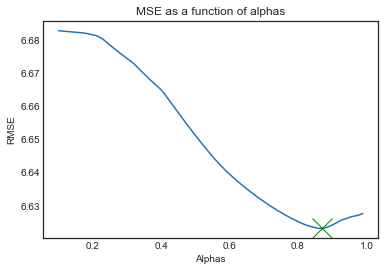

In [55]:
# Set alphas range
alphas = np.arange(0.1, 1, 0.01)

# Running LassoCV
lasso_cv = skl_lm.LassoCV(alphas=alphas, max_iter=100000, fit_intercept=True,
                          random_state=1, cv=10)
lasso_cv.fit(X_train, y_train)

# Get RMSE
rmse_cv = np.sqrt(np.mean(lasso_cv.mse_path_, axis=1))

# Find the min MSE and alpha
min_RMSE_index, min_RMSE = min(enumerate(rmse_cv), key=itemgetter(1))

# Plot out the MSE for best alpha
plt.plot(lasso_cv.alphas, rmse_cv)
plt.plot(alphas[min_RMSE_index+1], min_RMSE, color='g', marker='x', markersize=20)
plt.xlabel('Alphas')
plt.ylabel('RMSE')
plt.title('MSE as a function of alphas')

# Plug the best alpha in Lasso Regression
lasso = skl_lm.Lasso(alpha=lasso_cv.alpha_, fit_intercept=True, random_state=1, max_iter=100000)
lasso.fit(X_train, y_train)
mse = mean_squared_error(y_test, lasso.predict(X_test))
print('Validation set give RMSE of:', np.sqrt(mse))

# Fit ridge with full dataset
lasso.fit(X, y)

# Return the model with coefficients
print(pd.Series(lasso.coef_, index=X.columns))
print('Intercept: ', lasso.intercept_)

#### Nested 10-fold inside 10 fold

In [38]:
lasso_cv = skl_lm.LassoCV(alphas=alphas, fit_intercept=True,
                              max_iter=100000, cv=10, random_state=1)
score = cross_val_score(lasso_cv, X, y, cv=kf, scoring='neg_mean_squared_error').mean()
RMSE_dict['Lasso'] = np.sqrt(-1*score)

RMSE_dict

{'forward_select': 6.422392710151549,
 'Lasso': 6.591966036596754,
 'Ridge': 6.598973647546219}

#### Principal Component Regression(PCR)

Test RMSE with 13 PC: 6.628891442124997


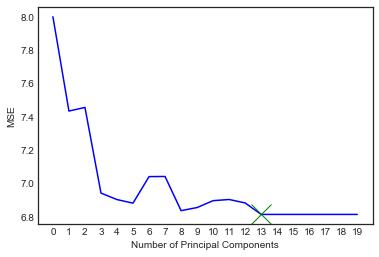

In [61]:
# Set up pca for train set
pca = PCA()
X_reduced_train = pca.fit_transform(scale(X_train))

# Set up mse
rmse = [8]  # For a better graph
regr = skl_lm.LinearRegression()

# Loop through all components number and K-fold
for i in range(1, 20):
    score = cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf, 
                            scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(-score))

# Getting minimum MSE
min_RMSE_index, min_RMSE = min(enumerate(rmse), key=itemgetter(1))

# Plot MSE
plt.plot(rmse, color='b')
plt.plot(min_RMSE_index, min_RMSE, color='g', marker='x', markersize=20)
plt.xticks(np.arange(0,20))
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')

# Transform X_test
X_reduced_test = pca.transform(scale(X_test))

# Get test error
y_pred = regr.fit(X_reduced_train[:,:14], y_train).predict(X_reduced_test[:,:14])

# Save RMSE
rmse_cv = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE with 13 PC: {rmse_cv}')

PCA with validation set advise us to use 13 components.

#### Conclusion: Which is best?

After all that analysis, there are not much differences in RMSE. While forward selection
and PCR wins out in RMSE, the lasso gives us a more interpretable model.

In the end, I would choose forward selection for its simplicity in implementing.

In [62]:
RMSE_dict['PCR'] = rmse_cv
RMSE_dict

{'forward_select': 6.422392710151549,
 'Lasso': 6.591966036596754,
 'Ridge': 6.598973647546219,
 'PCR': 6.628891442124997}